# Material de aula - Aprendizado de Máquina

Instruções para a realização desta atividade:

1. Faça o download deste notebook Jupyter para sua estação de trabalho
2. Realize as atividades solicitadas dentro do notebook, nos espaços apropriados e indicados
3. Salve o notebook no seguinte padrão: <nome_sobrenome_RA>.ipynb (por exemplo: **rodrigo_caropreso_123456.ipynb ** )
4. Envie o notebook com a atividade realizada na sala de aula da disciplina (Google Classroom)

** DATA DE ENTREGA DESTA ATIVIDADE: 29/12/2018 **

** VALOR DESTA ATIVIDADE: 3,0 pontos **


## RBF- Exercício 01

In [1]:
#CÉLULA RBF-LIB-01
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
#CÉLULA RBF-LIB-02
def euclidean_distance(v1, v2) :
    '''
    Esta função recebe 2 arrays (do tipo np.array) e retorna a distância euclidiana entre eles
    
    Parâmetros
    ----------
    v1 -> vetor de coordenadas do primeiro ponto
    v2 -> vetor de coordenadas do segundo ponto
    
    Retorno
    -------
    Distância entre os dois pontos    
    '''
    return np.sqrt( sum((v1 - v2)**2) )

In [3]:
#CÉLULA RBF-LIB-05
def kmeans(vData, nClusters) :
    '''
    Este método calcula os centroides dos clusters de um conjunto de dados a partir do algoritmo k-means
    
    Parâmetros
    ----------
    vData -> vetor de coordenadas N-Dimensionais dos dados. Cada posição do array deve ser uma lista de coordenadas
        
    Retorno
    -------
    Array contendo a lista de pontos observados, onde cada posição do array corresponde a um clusterId. 
    Cada ponto do array de retorno é definido como um dicionário com a seguinte estrutura:
        {
         'pointCoord'  : coordenadas do ponto, 
         'centerCoord' : coordenadas de seu centroide, 
         'clusterId'   : identificador do cluster
        }
    '''

    #Inicializa os centroides
    vClusterCenters = [vData[i] for i in range(0, nClusters)]
    
    vPoints = [{'point':point, 'clusterId' : -1, 'centerCoord' : point*0} for point in vData] #tupla (point, clusterCentroid)
    
    clusterIsChanging = True
    while(clusterIsChanging == True) :
    
        clusterIsChanging = False

        vClusterPoints  = [[]] * nClusters #cria lista de listas com tamanho nClusters. O indice primario corresponde a cada cluster

        for dataPoint in vPoints :
            vDistances = [ euclidean_distance(dataPoint['point'], center) for center in vClusterCenters ]
            clusterIndex = np.argmin(vDistances)

            if( dataPoint['clusterId'] != clusterIndex ) :
                dataPoint['clusterId']  = clusterIndex
                clusterIsChanging = True

        #Após a redistribuição dos pontos, recalcula os centroides
        for clusterIndex, clusterCenter in enumerate(vClusterCenters) :
            clusterData = [ point['point'] for point in vPoints if point['clusterId'] == clusterIndex ]
            vClusterCenters[clusterIndex] = np.mean(clusterData, axis=0) #atualiza centroide do cluster indicado pelo clusterIndex

    
    for dataPoint in vPoints :
        dataPoint['centerCoord'] = vClusterCenters[dataPoint['clusterId']]
                    
    return (vPoints, vClusterCenters)

In [4]:
#CÉLULA RBF-LIB-06
def cluster_distortion(vDataPoints, nClusters, bWeighted = False) :
    '''
    Esta função calcula a distorção intra-cluster
    
    Parâmetros
    ----------
    vDataPoints -> array contendo os pontos (dados observados). Cada ponto é definido como um dicionário com a seguinte estrutura
        {'pointCoord' : coordenadas do ponto, 'centerCoord' : coordenadas de seu centroide, 'clusterId' : identificador do cluster}
    
    nClusters   -> quantidade de clusters utilizados
    bWeighted   -> Se for definido como True, cada distorção será ponderada pelo numero de dados do cluster, resultando no 
                   cálculo da distância média quadrática (ou variância da função de ativação da RBF).
    
    Retorno
    -------
    
    Um array contendo a distorção intra-cluster de todos os clusters, onde cada posição do array corresponde ao clusterId    
    '''
    
    vClusterDist = []
    for i in range(nClusters) :
        vClusterPoints = [point for point in vDataPoints if point['clusterId'] == i]
        distance = sum([euclidean_distance(point['point'], point['centerCoord'])**2 for point in vClusterPoints])

        if( bWeighted == True) :
            distance /= len(vClusterPoints)
        
        vClusterDist.append(distance)
    
    return vClusterDist    

In [5]:
#CÉLULA RBF-LIB-08
def avgSquaredError(x, d, W_2) :
    '''
    Calula o Erro Quadratico Medio (ASE)
    
    Parametros
    ----------
    x   -> array de dados da entrada
    d   -> array de dados de saída
    W_2 -> pesos conectando as camadas de entrada e saida
    
    Retorno
    -------
    Valor do EQM para uma época de treinamento.    
    '''
    nSamples = np.shape(x)[1]
    I_2 = np.matmul(W_2, x)
    Y_2 = I_2 #Função de ativação linear
    
    E_k = (d - Y_2)**2
    E_k = np.sum(E_k, axis=0) / 2 #soma os elementos de cada coluna entre si
    ASE = sum(E_k) / nSamples # totaliza os elementos do array fazendo a media
    
    return ASE

In [6]:
#CÉLULA RBF-LIB-09
def rbf_stage1_training(vInputs, nHiddenLayer) :
    '''
    Realiza a fase 1 do treinamento da RBF.
    Espera-se x no formato [ neuronios x amostras ] de modo que a quantidade de neurons da camada oculta está nas linhas da 
    matriz x    
    '''
    (vPoints, vClusterCenters) = kmeans(vInputs, nHiddenLayer) 

    W_1 = np.array(vClusterCenters) #array de nClusters (linhas) por x entradas (colunas)

    #distorção de cada cluster = campo hiperesferico do neuronio da camada oculta = variancia
    #print(vClusterDist)
    clusterDist = cluster_distortion(vPoints, nHiddenLayer, True)
    sigmaSquared = np.array(clusterDist)

    return (W_1, sigmaSquared)

In [83]:
#CÉLULA RBF-LIB-10
def rbf_stage1_operation(vInputs, c, wVar) :
    '''Algoritmo de operação do RBF - Estagio 1
    
    Parametros
    -----------
    vInputs  : vetor/matriz com as entradas
    c        : vetor/matriz com os pesos
    wVar     : variância dos pesos
    
    Retorno
    -------
    Este método retorna o array de saida [amostras x neuronios] de saída do primeiro estágio da RBF calculado segundo 
    sua função de ativação gaussiana. Cada linha corresponde a uma amostra enquanto cada coluna corresponde a um neurônio da 
    camada oculta
    ''' 

    nSamples = len(vInputs)
    nNeurons = len(c)
    
    #Calcula saída da camada intermediária da RBF
    g = []
    for k in range(nSamples) :
        u = vInputs[k]
        z = (u - c)**2
        num = np.sum(z, axis=1)
        den = 2*wVar        
        g.append( np.exp( -num / den ) )

    return np.array(g)

In [77]:
#CÉLULA RBF-LIB-10
def rbf_stage1_operationX(vInputs, c, wVar,sq) :
    '''Algoritmo de operação do RBF - Estagio 1
    
    Parametros
    -----------
    vInputs  : vetor/matriz com as entradas
    c        : vetor/matriz com os pesos
    wVar     : variância dos pesos
    
    Retorno
    -------
    Este método retorna o array de saida [amostras x neuronios] de saída do primeiro estágio da RBF calculado segundo 
    sua função de ativação gaussiana. Cada linha corresponde a uma amostra enquanto cada coluna corresponde a um neurônio da 
    camada oculta
    ''' 

    nSamples = len(vInputs)
    nNeurons = len(c)
    
    #Calcula saída da camada intermediária da RBF
    g = []
    for k in range(nSamples) :
        u = vInputs[k]
        z = (u - c)**2
        num = np.sum(z, axis=1)
        den = 2*sq        
        g.append( np.exp( -num / den ) )

    return np.array(g)

In [8]:
#CÉLULA RBF-LIB-11
def rbf_stage2_training(eta, epsilon, vInputs, vOutputs, max_epochs, outLayerSize):
    '''
    Realiza a fase 2 do treinamento da RBF.
    Espera-se x no formato [ neuronios x amostras ] de modo que a quantidade de neurons da camada oculta está nas linhas da 
    matriz x
    '''
    
    nHiddenNeurons = np.shape(vInputs)[0]    
    nSamples = np.shape(vInputs)[1]
    W_2 = np.random.rand(outLayerSize, nHiddenNeurons)    
   
    vASE = []    
    currentASE = avgSquaredError(vInputs, vOutputs, W_2)
    #Guarda EQM atual
    vASE.append(currentASE)
        
    for epochCounter in range(1, max_epochs) :
        for k in range(nSamples) :
            #Forward Step - INICIO
            X = vInputs[:, [k]]
            d = vOutputs[:, [k]]
            
            I_2 =np.matmul(W_2, X)
            Y_2 = I_2 #função de ativação linear
            #Forward Step - FIM
        
            #Backward Step - INICIO
            delta_2 = d - Y_2 #gradiente da função linear é apenas a diferença entre valores
                        
            #Correção de pesos da camada de saída
            for j in range(outLayerSize) : #cada linha é um neuron de saida
                for i in range(nHiddenNeurons) : #cada coluna é uma sinapse com os neurons da camada oculta
                    W_2[j][i] += eta * delta_2[j] * X[i]
            #Backward Step - FIM
        
        #Fim do loop de amostras (época), calcula o erro
        currentASE = avgSquaredError(vInputs, vOutputs, W_2)
        #Guarda EQM atual
        vASE.append(currentASE)
        
        #Verifica criterio de parada, por convergência
        if( abs(vASE[epochCounter] - vASE[epochCounter-1]) <= epsilon ) :
            break
            
    return (W_2, vASE, epochCounter+1)        

In [9]:
#CÉLULA RBF-LIB-12
def rbf_stage2_operation(X, W_2):
    '''
    Espera-se x no formato [ neuronios x amostras ] de modo que a quantidade de neurons da camada oculta está nas linhas da 
    matriz x
    
    Espera-se W_2 no formato [ neuronios x sinapses] de modo que cada linha corresponde a um neuronio e cada coluna a uma sinapse
    '''    
    I_2 = np.matmul(W_2, X)
    Y_2 = I_2 #Função de ativação linear

    return Y_2

# Classificação de parâmetros de injeção eletrônica usando RBF

### A quantidade de gasolina {y} a ser injetada por um sistema de injeção eletrônica de combustível para veículos automotores pode ser computada em tempo-real em função de três grandezas {x1 , x2 , x3}. Devido à complexidade inerente do processo, configurado como um sistema não-linear, pretende-se utilizar uma rede neural artificial para o mapeamento entre as entradas e a saída do processo.

### Sabe-se que para efetuar o respectivo mapeamento (problema de aproximação funcional), duas potenciais arquiteturas podem ser aplicadas, a saber, o perceptron multicamadas ou a RBF. Dado que a equipe de engenheiros e cientistas já realizou o mapeamento do problema por meio do perceptron multicamadas, o objetivo agora é treinar uma RBF a fim de que os resultados fornecidos por ambas as arquiteturas possam ser contrastados.

### Assim, efetue o treinamento de uma RBF com o objetivo de computar a quantidade de gasolina {y} a ser injetada pelo sistema de injeção eletrônica em função das variáveis {x1 , x2 , x3}. A topologia da rede RBF está ilustrada na figura abaixo.

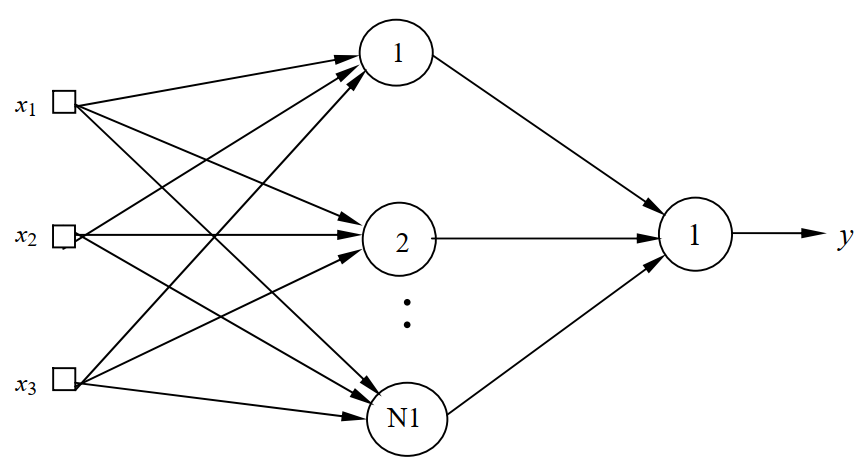


### As topologias candidatas de RBF para serem aplicadas no mapeamento do problema acima são especificadas como se segue:

1. Rede 1: RBF com N1 = 05
2. Rede 2: RBF com N1 = 10
3. Rede 3: RBF com N1 = 15

### Utilizando os dados de treinamento disponíveis no arquivo Injecao.csv, execute o treinamento das redes RBF conforme as topologias definidas acima. Para tanto, faça as seguintes atividades:

## 1 - Execute 3 treinamentos para cada topologia de rede RBF definida anteriormente, inicializando a matriz de pesos da camada de saída com valores aleatórios entre 0 e 1. Se for o caso, reinicie o gerador de números aleatórios em cada treinamento de tal forma que os elementos das matrizes de pesos iniciais não sejam os mesmos. Utilize uma taxa de aprendizado $\eta = 0.01$ e precisão $\epsilon = 10^{-7}$

## 2 - Registre os resultados finais desses 3 treinamentos (o Erro Quadrático Médio e a quantidade de épocas de treinamento), para cada uma das três topologias de rede, na tabela a seguir:


|Treinamento| Rede 1 - EQM | Rede 1 - Epocas | Rede 2 - EQM | Rede 2 - Epocas | Rede 3 - EQM | Rede 3 - Epocas |
|-----------|--------------|-----------------|--------------|-----------------|--------------|-----------------|
|   T1      | xxxxxxxxxxxx | xxxxxxxxxxxxxxx | xxxxxxxxxxxx | xxxxxxxxxxxxxxx | xxxxxxxxxxxx | xxxxxxxxxxxxxxx |
|   T2      | xxxxxxxxxxxx | xxxxxxxxxxxxxxx | xxxxxxxxxxxx | xxxxxxxxxxxxxxx | xxxxxxxxxxxx | xxxxxxxxxxxxxxx |
|   T3      | xxxxxxxxxxxx | xxxxxxxxxxxxxxx | xxxxxxxxxxxx | xxxxxxxxxxxxxxx | xxxxxxxxxxxx | xxxxxxxxxxxxxxx |

## 3 - Para todos os treinamentos efetuados no item 2, faça a validação da rede em relação aos valores desejados apresentados na tabela abaixo. Forneça para cada treinamento o erro relativo médio (%) entre os valores desejados e os valores fornecidos pela rede em relação a todos os padrões de teste. Obtenha também a respectiva variância (%)

|Amostra |  X1  |  X2  |  X3  |  yd  |R1:y(T1)|R1:y(T2)|R1:y(T3)|R2:y(T1)|R2:y(T2)|R2:y(T3)|R3:y(T1)|R3:y(T2)|R3:y(T3)|
|--------|------|------|------|------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
|   01   |0.5102|0.7464|0.0860|0.5965|0.607914|0.585695|0.590985|0.608008|0.585656|0.590980|0.607918|0.585656|0.590984|
|   02   |0.8401|0.4490|0.2719|0.6790|0.736162|0.674908|0.637738|0.736362|0.674873|0.637744|0.736229|0.674879|0.637740|
|   03   |0.1283|0.1882|0.7253|0.4662|0.435903|0.486097|0.508915|0.436286|0.486082|0.508914|0.435965|0.486073|0.508915|
|   04   |0.2299|0.1524|0.7353|0.5012|0.442742|0.504340|0.522716|0.443134|0.504327|0.522731|0.442822|0.504336|0.522719|
|   05   |0.3209|0.6229|0.5233|0.6810|0.702566|0.649191|0.664233|0.702759|0.649196|0.664232|0.702716|0.649222|0.664232|
|   06   |0.8203|0.0682|0.4260|0.5643|0.596429|0.532943|0.529177|0.595905|0.532956|0.529194|0.596320|0.532975|0.529181|
|   07   |0.3471|0.8889|0.1564|0.5875|0.543485|0.585710|0.600863|0.543317|0.585698|0.600902|0.543435|0.585718|0.600871|
|   08   |0.5762|0.8292|0.4116|0.7853|0.828580|0.759056|0.733367|0.829079|0.759064|0.733353|0.828749|0.759072|0.733364|
|   09   |0.9053|0.6245|0.5264|0.8506|0.824415|0.891361|0.815634|0.824778|0.891394|0.815626|0.824520|0.891390|0.815632|
|   10   |0.8149|0.0396|0.6227|0.6165|0.594992|0.593488|0.682391|0.594442|0.593497|0.682399|0.594868|0.593456|0.682393|
|   11   |0.1016|0.6382|0.3173|0.4957|0.463859|0.505445|0.529449|0.463743|0.505459|0.529436|0.463883|0.505476|0.529447|
|   12   |0.9108|0.2139|0.4641|0.6625|0.650662|0.614992|0.576952|0.650190|0.615001|0.576951|0.650576|0.614980|0.576952|
|   13   |0.2245|0.0971|0.6136|0.4402|0.371153|0.438607|0.470505|0.371693|0.438587|0.470507|0.371275|0.438600|0.470506|
|   14   |0.6423|0.3229|0.8567|0.7663|0.715049|0.758518|0.746852|0.714774|0.758524|0.746863|0.714995|0.758551|0.746854|
|   15   |0.5252|0.6529|0.5729|0.7893|0.883019|0.800925|0.755010|0.883362|0.800921|0.754993|0.883202|0.800939|0.755006|
    |   Erro Relativo Medio (%)  |-|-|-|-|0.06625535001777035|0.027796485169025133|0.10521763728912151|0.06626193424661149|0.027803870270557442|0.05755096483912568|0.06627660892682516|0.027801272898221808|0.057546488935512556|
|   Variância (%)            |-|-|-|-|0.1565084090126908|0.1299214622886934|0.10521763728912151|0.156528199476273|0.12992955293624567|0.10521338713223415|0.15653722876418344|0.1299306524531015|0.10521647062043624|


## 4- Para cada uma das topologias apresentadas na tabela acima, considerando ainda o melhor treinamento {T1, T2 ou T3} realizado em cada uma delas, trace o gráfico dos valores de erro quadrático médio (EQM) em função de cada época de treinamento. Plote os três gráficos.

## 5 - Baseado nas análises dos itens acima, indique qual das topologias candidatas {Rede 1, Rede 2 ou Rede 3} e com que qual configuração final de treinamento {T1, T2 ou T3} seria a mais adequada para este problema.

# RBF - Início

In [10]:
#CÉLULA RBF-MAIN-01
# Exercício 1 e 2
#Parâmetros
max_epochs = 10000
eta =  0.01
epsilon = 1e-07
#layersDescriptor = {'input' : 2, 'hidden' : 5, 'output' : 1} #descritor das camadas da RBF

layersDescriptor = []
layersDescriptor.append({'input' : 3, 'hidden' : 5, 'output' : 1}) #N1 = 05
layersDescriptor.append({'input' : 3, 'hidden' : 10, 'output' : 1}) #N1 = 10
layersDescriptor.append({'input' : 3, 'hidden' : 15, 'output' : 1}) #N1 = 15

In [11]:
#CÉLULA RBF-MAIN-02
#Carrega dados de treinamento e teste
dfTrainingFile = pd.read_csv('Exe01_Injection_training.csv')

dfOperationFile = pd.read_csv('Exe01_Injection_operation.csv')


In [118]:
#CÉLULA RBF-MAIN-03
# cria o dataframe da tabela do exercicio 2
df_resul_treinamentos = pd.DataFrame(columns=['Treinamento', 'Rede 1 - EQM', 'Rede 1 - Epocas', 'Rede 2 - EQM', 'Rede 2 - Epocas', 'Rede 3 - EQM', 'Rede 3 - Epocas'])
#guarda os valores pro exercicio 3 ficar mais automatizado
lista_w1 = []
lista_sq = []
lista_w2 = []
lista_nEpo = []
lista_vError = []
lista_eqm=[]
for i in range(1, 4): # executa 3 vezes os treinamentos para cada rede
    
    resul = {
        'Treinamento': 'T' + str(i) #T1,T2,TX
    }
    
    j = 1 
    for ld in layersDescriptor: # percorre a lista de redes para começar a executar os treinamentos em cada rede
        #CÉLULA RBF-MAIN-03
        nSamples = len(dfTrainingFile)
        vInputs  = np.array(dfTrainingFile.loc[: , 'x1':'x3'])
        vOutputs = np.array(dfTrainingFile.loc[: , 'yd'])

        #PRIMEIRO ESTAGIO DE TREINAMENTO: Alocação dos neuronios da camada oculta
        ''' 
        {
            'pointCoord'  : coordenadas do ponto, 
            'centerCoord' : coordenadas de seu centroide, 
            'clusterId'   : identificador do cluster
        }
        '''

        #implemente o código para realização do treinamento
        (W_1, sigmaSquared) = rbf_stage1_training(vInputs, ld['hidden'])
        lista_w1.append(W_1)
        lista_sq.append(sigmaSquared)
        #PREPARAÇAO PARA SEGUNDO ESTAGIO DE TREINAMENTO
        #PRIMEIRO ESTAGIO DE OPERAÇÃO
        Y_1 = rbf_stage1_operation(vInputs, W_1, sigmaSquared)
        
        #print(type(W_1))
        
        # SEGUNDO ESTAGIO DE TREINAMENTO : Ajuste dos pesos da camada de saída
        nSamples = Y_1.shape[0]
        col0 = np.ones((nSamples, 1)) * (-1)
        vInputsWithBias = np.array(col0)
        vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)
        #print(vInputsWithBias.T.shape)

        #Treinamento
        vOutputs = np.reshape(vOutputs, (len(vOutputs),  ld['output'])).T

        (W_2, vError, nEpochs) = rbf_stage2_training(eta, epsilon, vInputsWithBias.T, vOutputs, max_epochs, ld['output'])
        lista_w2.append(W_2)
        lista_vError.append(vError)
        lista_nEpo.append(nEpochs)
        erro = avgSquaredError(vInputsWithBias.T, vOutputs, W_2)
        lista_eqm.append(erro)
        resul['Rede '+str(j)+' - EQM'] = erro
        resul['Rede '+str(j)+' - Epocas'] = nEpochs
        j = j+1
        
    df_resul_treinamentos = df_resul_treinamentos.append(resul, ignore_index=True)

df_resul_treinamentos


,Treinamento,Rede 1 - EQM,Rede 1 - Epocas,Rede 2 - EQM,Rede 2 - Epocas,Rede 3 - EQM,Rede 3 - Epocas
0,T1,0.004323,117,0.002949,342,0.001915,844
1,T2,0.004323,132,0.002950,335,0.001915,845
2,T3,0.004323,135,0.002949,299,0.001915,892


In [68]:
print(type(lista_w1[0]))

<class 'numpy.ndarray'>


## Implemente a expressão que calcula o Erro Relativo médio e a variância, para inserir os dados na tabela acima

$$ MRE = \frac{|valor\_aprox - valor\_exato |}{valor\_exato} \times 100 \% $$

### Lembre-se que a expressão acima calcula somente o erro relativo para UM PAR (Y_previsto, Y_esperado). O Erro relativo médio será a MÉDIA dos Erros Relativos para todos os pares (Y_previsto, Y_esperado) do conjunto de testes.

In [36]:
#Erro Relativo Médio
def erroRelMedioVar(dataDx):
    valor = 0
    diff = 0
    for index, row in dataDx.iterrows():
        diff = row['y'] - row['yd']
        valor += ( ( abs(diff) / row['yd'] ) * 1 )

    REM = valor / len(dataDx)
    return REM, dataDx['y'].std()


In [102]:
# Exercício 3
#implemente o código para realização do teste

#vamos usar os valores guardados nas listas onde:
# indices 0,1,2 = rede 1, 3 treinamentos
# indices 3,4,5 = rede 2, 3 treinamentos
# indices 6,7,8 = rede 3, 3 treinamentos


#REDE 1 T1
nSamples = len(dfOperationFile)
    
vInputs  = np.array(dfOperationFile.loc[: , 'x1':'x3'])# x1 ~x3
vOutputs = np.array(dfOperationFile.loc[: , 'yd'])#resul

    
#PRIMEIRO ESTAGIO DE OPERAÇÃO

Y_1 = rbf_stage1_operation(vInputs, lista_w1[0], lista_sq[0])

nSamples = Y_1.shape[0]
col0 = np.ones((nSamples, 1)) * (-1)
vInputsWithBias = np.array(col0)
vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)

#SEGUNDO ESTAGIO DE OPERAÇÃO
Y_2 = rbf_stage2_operation(vInputsWithBias.T, lista_w2[0])

# Pos processamneto
Y_2_processed = []
for k in range(nSamples) :
    if (Y_2[:,k] < 0) :
        Y_2_processed.append(-1)
    else:
        Y_2_processed.append(1)

#print(Y_2_processed)
#print(vOutputs)


y=[]


#Adicionando todas as colunas ao dataframe
dataD_r1t1 = dfOperationFile.copy()
#dataD['y'] = Y_2
dataD_r1t1 = dataD.assign(y=pd.Series(Y_2[0,:]), y_pos=pd.Series(Y_2_processed))
dataD_r1t1


(erroR1T1,varR1T1) = erroRelMedioVar(dataD_r1t1)

print('Rede 1 treinamento 1')
print('Erro Relativo médio: '+ str(erroR1T1))
print('Variancia: ' + str(varR1T1))

dataD_r1t1

Rede 1 treinamento 1
Erro Relativo médio: 0.06625535001777035
Variancia: 0.1565084090126908


,x1,x2,x3,yd,y,y_pos
0,0.5102,0.7464,0.0860,0.5965,0.607914,1
1,0.8401,0.4490,0.2719,0.6790,0.736162,1
2,0.1283,0.1882,0.7253,0.4662,0.435903,1
3,0.2299,0.1524,0.7353,0.5012,0.442742,1
4,0.3209,0.6229,0.5233,0.6810,0.702566,1
5,0.8203,0.0682,0.4260,0.5643,0.596429,1
6,0.3471,0.8889,0.1564,0.5875,0.543485,1
7,0.5762,0.8292,0.4116,0.7853,0.828580,1
8,0.9053,0.6245,0.5264,0.8506,0.824415,1
9,0.8149,0.0396,0.6227,0.6165,0.594992,1


In [105]:
# Exercício 3
#implemente o código para realização do teste

#vamos usar os valores guardados nas listas onde:
# indices 0,1,2 = rede 1, 3 treinamentos
# indices 3,4,5 = rede 2, 3 treinamentos
# indices 6,7,8 = rede 3, 3 treinamentos


#REDE 1 T2
nSamples = len(dfOperationFile)
    
vInputs  = np.array(dfOperationFile.loc[: , 'x1':'x3'])# x1 ~x3
vOutputs = np.array(dfOperationFile.loc[: , 'yd'])#resul

    
#PRIMEIRO ESTAGIO DE OPERAÇÃO

Y_1 = rbf_stage1_operation(vInputs, lista_w1[1], lista_sq[1])

nSamples = Y_1.shape[0]
col0 = np.ones((nSamples, 1)) * (-1)
vInputsWithBias = np.array(col0)
vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)

#SEGUNDO ESTAGIO DE OPERAÇÃO
Y_2 = rbf_stage2_operation(vInputsWithBias.T, lista_w2[1])

# Pos processamneto
Y_2_processed = []
for k in range(nSamples) :
    if (Y_2[:,k] < 0) :
        Y_2_processed.append(-1)
    else:
        Y_2_processed.append(1)

#print(Y_2_processed)
#print(vOutputs)


y=[]



#Adicionando todas as colunas ao dataframe
dataD_r1t2 = dfOperationFile.copy()
#dataD['y'] = Y_2
dataD_r1t2 = dataD.assign(y=pd.Series(Y_2[0,:]), y_pos=pd.Series(Y_2_processed))
dataD_r1t2


(erroR1T2,varR1T2) = erroRelMedioVar(dataD_r1t2)


print('Rede 1 treinamento 2')
print('Erro Relativo médio: '+ str(erroR1T2))
print('Variancia: ' + str(varR1T2))
dataD_r1t2

Rede 1 treinamento 2
Erro Relativo médio: 0.027796485169025133
Variancia: 0.1299214622886934


,x1,x2,x3,yd,y,y_pos
0,0.5102,0.7464,0.0860,0.5965,0.585695,1
1,0.8401,0.4490,0.2719,0.6790,0.674908,1
2,0.1283,0.1882,0.7253,0.4662,0.486097,1
3,0.2299,0.1524,0.7353,0.5012,0.504340,1
4,0.3209,0.6229,0.5233,0.6810,0.649191,1
5,0.8203,0.0682,0.4260,0.5643,0.532943,1
6,0.3471,0.8889,0.1564,0.5875,0.585710,1
7,0.5762,0.8292,0.4116,0.7853,0.759056,1
8,0.9053,0.6245,0.5264,0.8506,0.891361,1
9,0.8149,0.0396,0.6227,0.6165,0.593488,1


In [103]:
# Exercício 3
#implemente o código para realização do teste

#vamos usar os valores guardados nas listas onde:
# indices 0,1,2 = rede 1, 3 treinamentos
# indices 3,4,5 = rede 2, 3 treinamentos
# indices 6,7,8 = rede 3, 3 treinamentos


#REDE 1 T3
nSamples = len(dfOperationFile)
    
vInputs  = np.array(dfOperationFile.loc[: , 'x1':'x3'])# x1 ~x3
vOutputs = np.array(dfOperationFile.loc[: , 'yd'])#resul

    
#PRIMEIRO ESTAGIO DE OPERAÇÃO

Y_1 = rbf_stage1_operation(vInputs, lista_w1[2], lista_sq[2])

nSamples = Y_1.shape[0]
col0 = np.ones((nSamples, 1)) * (-1)
vInputsWithBias = np.array(col0)
vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)

#SEGUNDO ESTAGIO DE OPERAÇÃO
Y_2 = rbf_stage2_operation(vInputsWithBias.T, lista_w2[2])

# Pos processamneto
Y_2_processed = []
for k in range(nSamples) :
    if (Y_2[:,k] < 0) :
        Y_2_processed.append(-1)
    else:
        Y_2_processed.append(1)

#print(Y_2_processed)
#print(vOutputs)


y=[]

#Adicionando todas as colunas ao dataframe
dataD_r1t3 = dfOperationFile.copy()
#dataD['y'] = Y_2
dataD_r1t3 = dataD.assign(y=pd.Series(Y_2[0,:]), y_pos=pd.Series(Y_2_processed))
dataD_r1t3


(R1T3,R1T3) = erroRelMedioVar(dataD_r1t3)


print('Rede 1 treinamento 3')
print('Erro Relativo médio: '+ str(R1T3))
print('Variancia: ' + str(R1T3))

dataD_r1t3

Rede 1 treinamento 3
Erro Relativo médio: 0.10521763728912151
Variancia: 0.10521763728912151


,x1,x2,x3,yd,y,y_pos
0,0.5102,0.7464,0.0860,0.5965,0.590985,1
1,0.8401,0.4490,0.2719,0.6790,0.637738,1
2,0.1283,0.1882,0.7253,0.4662,0.508915,1
3,0.2299,0.1524,0.7353,0.5012,0.522716,1
4,0.3209,0.6229,0.5233,0.6810,0.664233,1
5,0.8203,0.0682,0.4260,0.5643,0.529177,1
6,0.3471,0.8889,0.1564,0.5875,0.600863,1
7,0.5762,0.8292,0.4116,0.7853,0.733367,1
8,0.9053,0.6245,0.5264,0.8506,0.815634,1
9,0.8149,0.0396,0.6227,0.6165,0.682391,1


In [106]:
# Exercício 3
#implemente o código para realização do teste

#vamos usar os valores guardados nas listas onde:
# indices 0,1,2 = rede 1, 3 treinamentos
# indices 3,4,5 = rede 2, 3 treinamentos
# indices 6,7,8 = rede 3, 3 treinamentos


#REDE 2 T1
nSamples = len(dfOperationFile)
    
vInputs  = np.array(dfOperationFile.loc[: , 'x1':'x3'])# x1 ~x3
vOutputs = np.array(dfOperationFile.loc[: , 'yd'])#resul

    
#PRIMEIRO ESTAGIO DE OPERAÇÃO

Y_1 = rbf_stage1_operation(vInputs, lista_w1[3], lista_sq[3])

nSamples = Y_1.shape[0]
col0 = np.ones((nSamples, 1)) * (-1)
vInputsWithBias = np.array(col0)
vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)

#SEGUNDO ESTAGIO DE OPERAÇÃO
Y_2 = rbf_stage2_operation(vInputsWithBias.T, lista_w2[3])

# Pos processamneto
Y_2_processed = []
for k in range(nSamples) :
    if (Y_2[:,k] < 0) :
        Y_2_processed.append(-1)
    else:
        Y_2_processed.append(1)

#print(Y_2_processed)
#print(vOutputs)


y=[]

#Adicionando todas as colunas ao dataframe
dataD_r2t1 = dfOperationFile.copy()
#dataD['y'] = Y_2
dataD_r2t1 = dataD.assign(y=pd.Series(Y_2[0,:]), y_pos=pd.Series(Y_2_processed))

(erroR2T1,varR2T1) = erroRelMedioVar(dataD_r2t1)


print('Rede 2 treinamento 1')
print('Erro Relativo médio: '+ str(erroR2T1))
print('Variancia: ' + str(varR2T1))

dataD_r2t1

Rede 2 treinamento 1
Erro Relativo médio: 0.06626193424661149
Variancia: 0.156528199476273


,x1,x2,x3,yd,y,y_pos
0,0.5102,0.7464,0.0860,0.5965,0.608008,1
1,0.8401,0.4490,0.2719,0.6790,0.736362,1
2,0.1283,0.1882,0.7253,0.4662,0.436286,1
3,0.2299,0.1524,0.7353,0.5012,0.443134,1
4,0.3209,0.6229,0.5233,0.6810,0.702759,1
5,0.8203,0.0682,0.4260,0.5643,0.595905,1
6,0.3471,0.8889,0.1564,0.5875,0.543317,1
7,0.5762,0.8292,0.4116,0.7853,0.829079,1
8,0.9053,0.6245,0.5264,0.8506,0.824778,1
9,0.8149,0.0396,0.6227,0.6165,0.594442,1


In [110]:
# Exercício 3
#implemente o código para realização do teste

#vamos usar os valores guardados nas listas onde:
# indices 0,1,2 = rede 1, 3 treinamentos
# indices 3,4,5 = rede 2, 3 treinamentos
# indices 6,7,8 = rede 3, 3 treinamentos


#REDE 2 T2
nSamples = len(dfOperationFile)
    
vInputs  = np.array(dfOperationFile.loc[: , 'x1':'x3'])# x1 ~x3
vOutputs = np.array(dfOperationFile.loc[: , 'yd'])#resul

    
#PRIMEIRO ESTAGIO DE OPERAÇÃO

Y_1 = rbf_stage1_operation(vInputs, lista_w1[4], lista_sq[4])

nSamples = Y_1.shape[0]
col0 = np.ones((nSamples, 1)) * (-1)
vInputsWithBias = np.array(col0)
vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)

#SEGUNDO ESTAGIO DE OPERAÇÃO
Y_2 = rbf_stage2_operation(vInputsWithBias.T, lista_w2[4])

# Pos processamneto
Y_2_processed = []
for k in range(nSamples) :
    if (Y_2[:,k] < 0) :
        Y_2_processed.append(-1)
    else:
        Y_2_processed.append(1)

#print(Y_2_processed)
#print(vOutputs)


y=[]

#Adicionando todas as colunas ao dataframe
dataD_r2t2 = dfOperationFile.copy()
#dataD['y'] = Y_2
dataD_r2t2 = dataD.assign(y=pd.Series(Y_2[0,:]), y_pos=pd.Series(Y_2_processed))

(erroR2T2,varR2T2) = erroRelMedioVar(dataD_r2t2)


print('Rede 2 treinamento 2')
print('Erro Relativo médio: '+ str(erroR2T2))
print('Variancia: ' + str(varR2T2))

dataD_r2t2

Rede 2 treinamento 2
Erro Relativo médio: 0.027803870270557442
Variancia: 0.12992955293624567


,x1,x2,x3,yd,y,y_pos
0,0.5102,0.7464,0.0860,0.5965,0.585656,1
1,0.8401,0.4490,0.2719,0.6790,0.674873,1
2,0.1283,0.1882,0.7253,0.4662,0.486082,1
3,0.2299,0.1524,0.7353,0.5012,0.504327,1
4,0.3209,0.6229,0.5233,0.6810,0.649196,1
5,0.8203,0.0682,0.4260,0.5643,0.532956,1
6,0.3471,0.8889,0.1564,0.5875,0.585698,1
7,0.5762,0.8292,0.4116,0.7853,0.759064,1
8,0.9053,0.6245,0.5264,0.8506,0.891394,1
9,0.8149,0.0396,0.6227,0.6165,0.593497,1


In [111]:
# Exercício 3
#implemente o código para realização do teste

#vamos usar os valores guardados nas listas onde:
# indices 0,1,2 = rede 1, 3 treinamentos
# indices 3,4,5 = rede 2, 3 treinamentos
# indices 6,7,8 = rede 3, 3 treinamentos


#REDE 2 T3
nSamples = len(dfOperationFile)
    
vInputs  = np.array(dfOperationFile.loc[: , 'x1':'x3'])# x1 ~x3
vOutputs = np.array(dfOperationFile.loc[: , 'yd'])#resul

    
#PRIMEIRO ESTAGIO DE OPERAÇÃO

Y_1 = rbf_stage1_operation(vInputs, lista_w1[5], lista_sq[5])

nSamples = Y_1.shape[0]
col0 = np.ones((nSamples, 1)) * (-1)
vInputsWithBias = np.array(col0)
vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)

#SEGUNDO ESTAGIO DE OPERAÇÃO
Y_2 = rbf_stage2_operation(vInputsWithBias.T, lista_w2[5])

# Pos processamneto
Y_2_processed = []
for k in range(nSamples) :
    if (Y_2[:,k] < 0) :
        Y_2_processed.append(-1)
    else:
        Y_2_processed.append(1)

#print(Y_2_processed)
#print(vOutputs)


y=[]

#Adicionando todas as colunas ao dataframe
dataD_r2t3 = dfOperationFile.copy()
#dataD['y'] = Y_2
dataD_r2t3 = dataD.assign(y=pd.Series(Y_2[0,:]), y_pos=pd.Series(Y_2_processed))

(erroR2T3,varR2T3) = erroRelMedioVar(dataD_r2t3)


print('Rede 2 treinamento 3')
print('Erro Relativo médio: '+ str(erroR2T3))
print('Variancia: ' + str(varR2T3))

dataD_r2t3

Rede 2 treinamento 3
Erro Relativo médio: 0.05755096483912568
Variancia: 0.10521338713223415


,x1,x2,x3,yd,y,y_pos
0,0.5102,0.7464,0.0860,0.5965,0.590980,1
1,0.8401,0.4490,0.2719,0.6790,0.637744,1
2,0.1283,0.1882,0.7253,0.4662,0.508914,1
3,0.2299,0.1524,0.7353,0.5012,0.522731,1
4,0.3209,0.6229,0.5233,0.6810,0.664232,1
5,0.8203,0.0682,0.4260,0.5643,0.529194,1
6,0.3471,0.8889,0.1564,0.5875,0.600902,1
7,0.5762,0.8292,0.4116,0.7853,0.733353,1
8,0.9053,0.6245,0.5264,0.8506,0.815626,1
9,0.8149,0.0396,0.6227,0.6165,0.682399,1


In [113]:
# Exercício 3
#implemente o código para realização do teste

#vamos usar os valores guardados nas listas onde:
# indices 0,1,2 = rede 1, 3 treinamentos
# indices 3,4,5 = rede 2, 3 treinamentos
# indices 6,7,8 = rede 3, 3 treinamentos


#REDE 3 T1
nSamples = len(dfOperationFile)
    
vInputs  = np.array(dfOperationFile.loc[: , 'x1':'x3'])# x1 ~x3
vOutputs = np.array(dfOperationFile.loc[: , 'yd'])#resul

    
#PRIMEIRO ESTAGIO DE OPERAÇÃO

Y_1 = rbf_stage1_operation(vInputs, lista_w1[6], lista_sq[6])

nSamples = Y_1.shape[0]
col0 = np.ones((nSamples, 1)) * (-1)
vInputsWithBias = np.array(col0)
vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)

#SEGUNDO ESTAGIO DE OPERAÇÃO
Y_2 = rbf_stage2_operation(vInputsWithBias.T, lista_w2[6])

# Pos processamneto
Y_2_processed = []
for k in range(nSamples) :
    if (Y_2[:,k] < 0) :
        Y_2_processed.append(-1)
    else:
        Y_2_processed.append(1)

#print(Y_2_processed)
#print(vOutputs)


y=[]

#Adicionando todas as colunas ao dataframe
dataD_r3t1 = dfOperationFile.copy()
#dataD['y'] = Y_2
dataD_r3t1 = dataD.assign(y=pd.Series(Y_2[0,:]), y_pos=pd.Series(Y_2_processed))

(erroR3T1,varR3T1) = erroRelMedioVar(dataD_r3t1)


print('Rede 3 treinamento 1')
print('Erro Relativo médio: '+ str(erroR3T1))
print('Variancia: ' + str(varR3T1))

dataD_r3t1

Rede 3 treinamento 1
Erro Relativo médio: 0.06627660892682516
Variancia: 0.15653722876418344


,x1,x2,x3,yd,y,y_pos
0,0.5102,0.7464,0.0860,0.5965,0.607918,1
1,0.8401,0.4490,0.2719,0.6790,0.736229,1
2,0.1283,0.1882,0.7253,0.4662,0.435965,1
3,0.2299,0.1524,0.7353,0.5012,0.442822,1
4,0.3209,0.6229,0.5233,0.6810,0.702716,1
5,0.8203,0.0682,0.4260,0.5643,0.596320,1
6,0.3471,0.8889,0.1564,0.5875,0.543435,1
7,0.5762,0.8292,0.4116,0.7853,0.828749,1
8,0.9053,0.6245,0.5264,0.8506,0.824520,1
9,0.8149,0.0396,0.6227,0.6165,0.594868,1


In [116]:
# Exercício 3
#implemente o código para realização do teste

#vamos usar os valores guardados nas listas onde:
# indices 0,1,2 = rede 1, 3 treinamentos
# indices 3,4,5 = rede 2, 3 treinamentos
# indices 6,7,8 = rede 3, 3 treinamentos


#REDE 3 T1
nSamples = len(dfOperationFile)
    
vInputs  = np.array(dfOperationFile.loc[: , 'x1':'x3'])# x1 ~x3
vOutputs = np.array(dfOperationFile.loc[: , 'yd'])#resul

    
#PRIMEIRO ESTAGIO DE OPERAÇÃO

Y_1 = rbf_stage1_operation(vInputs, lista_w1[7], lista_sq[7])

nSamples = Y_1.shape[0]
col0 = np.ones((nSamples, 1)) * (-1)
vInputsWithBias = np.array(col0)
vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)

#SEGUNDO ESTAGIO DE OPERAÇÃO
Y_2 = rbf_stage2_operation(vInputsWithBias.T, lista_w2[7])

# Pos processamneto
Y_2_processed = []
for k in range(nSamples) :
    if (Y_2[:,k] < 0) :
        Y_2_processed.append(-1)
    else:
        Y_2_processed.append(1)

#print(Y_2_processed)
#print(vOutputs)


y=[]

#Adicionando todas as colunas ao dataframe
dataD_r3t2 = dfOperationFile.copy()
#dataD['y'] = Y_2
dataD_r3t2 = dataD.assign(y=pd.Series(Y_2[0,:]), y_pos=pd.Series(Y_2_processed))

(erroR3T2,varR3T2) = erroRelMedioVar(dataD_r3t2)


print('Rede 3 treinamento 2')
print('Erro Relativo médio: '+ str(erroR3T2))
print('Variancia: ' + str(varR3T2))

dataD_r3t2

Rede 3 treinamento 2
Erro Relativo médio: 0.027801272898221808
Variancia: 0.1299306524531015


,x1,x2,x3,yd,y,y_pos
0,0.5102,0.7464,0.0860,0.5965,0.585656,1
1,0.8401,0.4490,0.2719,0.6790,0.674879,1
2,0.1283,0.1882,0.7253,0.4662,0.486073,1
3,0.2299,0.1524,0.7353,0.5012,0.504336,1
4,0.3209,0.6229,0.5233,0.6810,0.649222,1
5,0.8203,0.0682,0.4260,0.5643,0.532975,1
6,0.3471,0.8889,0.1564,0.5875,0.585718,1
7,0.5762,0.8292,0.4116,0.7853,0.759072,1
8,0.9053,0.6245,0.5264,0.8506,0.891390,1
9,0.8149,0.0396,0.6227,0.6165,0.593456,1


In [117]:
# Exercício 3
#implemente o código para realização do teste

#vamos usar os valores guardados nas listas onde:
# indices 0,1,2 = rede 1, 3 treinamentos
# indices 3,4,5 = rede 2, 3 treinamentos
# indices 6,7,8 = rede 3, 3 treinamentos


#REDE 3 T1
nSamples = len(dfOperationFile)
    
vInputs  = np.array(dfOperationFile.loc[: , 'x1':'x3'])# x1 ~x3
vOutputs = np.array(dfOperationFile.loc[: , 'yd'])#resul

    
#PRIMEIRO ESTAGIO DE OPERAÇÃO

Y_1 = rbf_stage1_operation(vInputs, lista_w1[8], lista_sq[8])

nSamples = Y_1.shape[0]
col0 = np.ones((nSamples, 1)) * (-1)
vInputsWithBias = np.array(col0)
vInputsWithBias = np.append(vInputsWithBias, Y_1, axis=1)

#SEGUNDO ESTAGIO DE OPERAÇÃO
Y_2 = rbf_stage2_operation(vInputsWithBias.T, lista_w2[8])

# Pos processamneto
Y_2_processed = []
for k in range(nSamples) :
    if (Y_2[:,k] < 0) :
        Y_2_processed.append(-1)
    else:
        Y_2_processed.append(1)

#print(Y_2_processed)
#print(vOutputs)


y=[]

#Adicionando todas as colunas ao dataframe
dataD_r3t3 = dfOperationFile.copy()
#dataD['y'] = Y_2
dataD_r3t3 = dataD.assign(y=pd.Series(Y_2[0,:]), y_pos=pd.Series(Y_2_processed))

(erroR3T3,varR3T3) = erroRelMedioVar(dataD_r3t3)


print('Rede 3 treinamento 3')
print('Erro Relativo médio: '+ str(erroR3T3))
print('Variancia: ' + str(varR3T3))

dataD_r3t3

Rede 3 treinamento 3
Erro Relativo médio: 0.057546488935512556
Variancia: 0.10521647062043624


,x1,x2,x3,yd,y,y_pos
0,0.5102,0.7464,0.0860,0.5965,0.590984,1
1,0.8401,0.4490,0.2719,0.6790,0.637740,1
2,0.1283,0.1882,0.7253,0.4662,0.508915,1
3,0.2299,0.1524,0.7353,0.5012,0.522719,1
4,0.3209,0.6229,0.5233,0.6810,0.664232,1
5,0.8203,0.0682,0.4260,0.5643,0.529181,1
6,0.3471,0.8889,0.1564,0.5875,0.600871,1
7,0.5762,0.8292,0.4116,0.7853,0.733364,1
8,0.9053,0.6245,0.5264,0.8506,0.815632,1
9,0.8149,0.0396,0.6227,0.6165,0.682393,1


In [154]:
print(lista_nEpo)

[117, 342, 844, 132, 335, 845, 135, 299, 892]


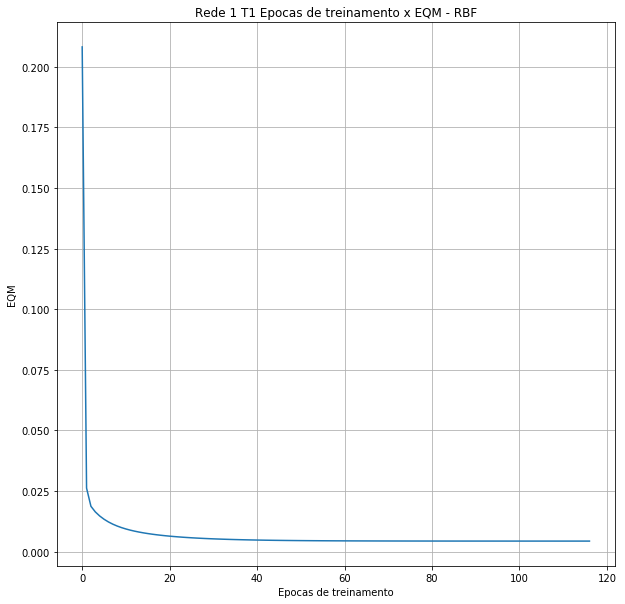

In [160]:
#Exercicio 4
#CÉLULA RBF-MAIN-04
# Plotando o Erro Quadrático Médio
fig = plt.figure(figsize=(10,10))
plt.grid()
plt.xlabel('Epocas de treinamento')
plt.ylabel('EQM')
plt.title('Rede 1 T1 Epocas de treinamento x EQM - RBF')
plt.plot(range(lista_nEpo[0]), lista_vError[0])

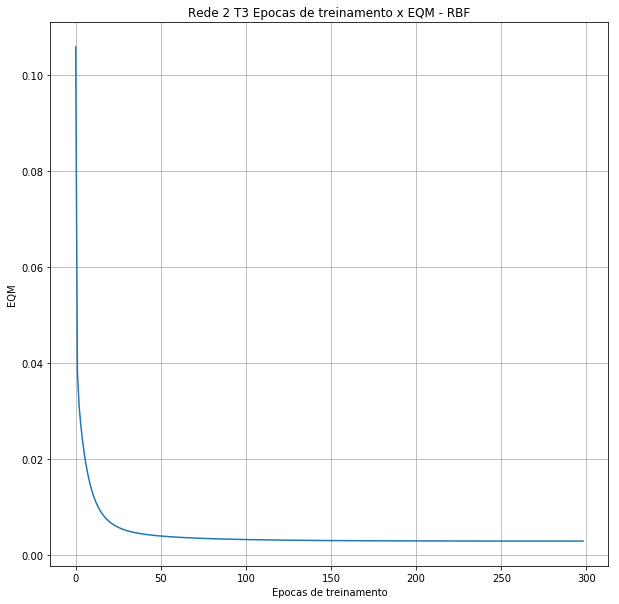

In [161]:
#CÉLULA RBF-MAIN-04
#Exercicio 4
# Plotando o Erro Quadrático Médio
fig = plt.figure(figsize=(10,10))
plt.grid()
plt.xlabel('Epocas de treinamento')
plt.ylabel('EQM')
plt.title('Rede 2 T3 Epocas de treinamento x EQM - RBF')
plt.plot(range(lista_nEpo[7]), lista_vError[7])

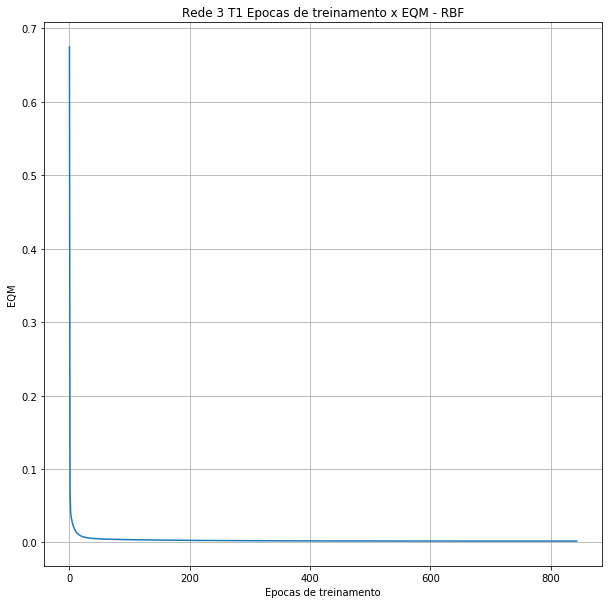

In [162]:
#CÉLULA RBF-MAIN-04
#Exercicio 4
# Plotando o Erro Quadrático Médio
fig = plt.figure(figsize=(10,10))
plt.grid()
plt.xlabel('Epocas de treinamento')
plt.ylabel('EQM')
plt.title('Rede 3 T1 Epocas de treinamento x EQM - RBF')
plt.plot(range(lista_nEpo[2]), lista_vError[2])

**Resposta 5**

Como podemos ver a Rede3 no primeiro treinamento atingiu 844 epocas, usando 5 neuronios
a Rede2 com 299 épocas  no treinamento 3 usando 15 neuronios
Já a Rede1 com 117 épocas no com 5 neuronios no primeiro treinamento.

No geral o EQM das redes variou muito pouco ou ficou igual